In [1]:
import torch
import torchvision

from models.nn import ShiftedConv
from models.convnext import ConvNeXt
import train

/home/S-rs/miniforge3/envs/embed_time/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GPU = 0
patience = 10
seed = 1
crop_size = 280


torch.manual_seed(seed)
device = torch.device(f"cuda:{str(GPU)}")

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.n_images = len(images)
        self.transform = transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
mnist = torchvision.datasets.MNIST("./data", download=True)

In [5]:
classes = []
for i in range(10):
    current_class = (mnist.targets == i).nonzero()
    classes.append(current_class[:, 0])

n_images = 1000

sorted_mnist = []
classes_ok = True
while classes_ok and len(sorted_mnist) < n_images:
    time_series = []
    for i in range(10):
        img = mnist[classes[i][-1].item()][0]
        img = torchvision.transforms.functional.pil_to_tensor(img)[None]
        img = torch.nn.functional.interpolate(img, scale_factor=10)
        time_series.append(img)
        classes[i] = classes[i][:-1]
        if len(classes[i]) == 0:
            classes_ok = False
    time_series = torch.stack(time_series, dim=2)
    sorted_mnist.append(time_series)
sorted_mnist = torch.cat(sorted_mnist, dim=0).to(torch.float)

sorted_mnist = sorted_mnist.unfold(2, 5, 5)
sorted_mnist = sorted_mnist.movedim(2, 1)
sorted_mnist = sorted_mnist.flatten(0, 1)
sorted_mnist = sorted_mnist.movedim(4, 2)
print(sorted_mnist.shape)

sorted_mnist -= sorted_mnist.mean()
sorted_mnist /= sorted_mnist.std()

n_time = sorted_mnist.shape[2]

torch.Size([2000, 1, 5, 280, 280])


In [19]:
transform = torchvision.transforms.RandomCrop(crop_size)
batch_size = 4
train_split = 0.9
train_set = sorted_mnist[: int(len(sorted_mnist) * 0.9)]
val_set = sorted_mnist[int(len(sorted_mnist) * 0.9) :]

train_set = Dataset(train_set, transform=transform)
val_set = Dataset(val_set, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    drop_last=True,
)

In [20]:
for i in val_loader:
    example_batch = i
example_batch.shape

torch.Size([4, 1, 5, 280, 280])

In [21]:
for batch in train_loader:
    example_mnist = batch
example_mnist[0].shape

torch.Size([1, 5, 280, 280])

In [22]:
for batch in val_loader:
    example = batch
    break
example.shape

torch.Size([4, 1, 5, 280, 280])

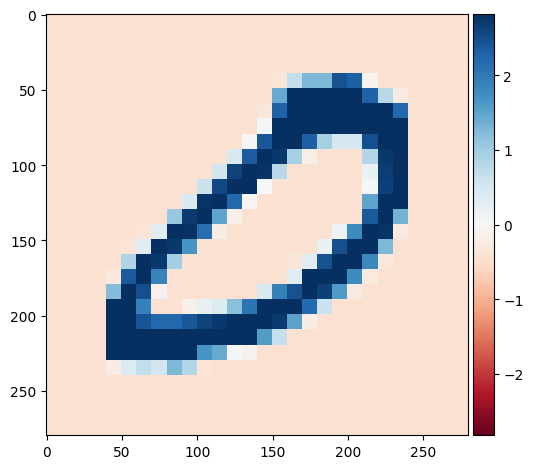

In [23]:
from skimage.io import imshow
imshow(train_set[0][0][0].numpy())

In [24]:
import torchvision.transforms as trans
from torchvision.transforms import v2
from embed_time.transforms import CustomToTensor, CropAndReshapeTL
from embed_time.dataloader_rs import LiveTLSDatasetPairedOutput

data_location = "/mnt/efs/dlmbl/G-et/data/live-TLS"

folder_imgs = data_location +"/"+'Control_Dataset_4TP_Normalized'
metadata = data_location + "/" +'Control_Dataset_4TP_Ground_Truth'

loading_transforms = trans.Compose([
    CropAndReshapeTL(1,0,598,0),
    CustomToTensor(),
    v2.Resize((576,576)),
    v2.RandomAffine(
        degrees=90,
        translate=[0.1,0.1],
    ),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.GaussianNoise(0,0.05)
])

dataset_w_t = LiveTLSDatasetPairedOutput(
    metadata,
    folder_imgs,
    indices=range(312),
    transform = loading_transforms,
)

In [25]:
dataset_w_t[0].shape

torch.Size([2, 4, 576, 576])

In [26]:
dataset_w_t[0][1].shape

torch.Size([4, 576, 576])

In [27]:
from sklearn.model_selection import train_test_split

dataset_length = 312  
train_indices, test_indices = train_test_split(range(dataset_length), test_size=0.2, shuffle=True)

In [36]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(
    LiveTLSDatasetPairedOutput(
        metadata,
        folder_imgs,
        indices=train_indices,
        transform = loading_transforms,
    ),
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
val_loader = torch.utils.data.DataLoader(
        LiveTLSDatasetPairedOutput(
        metadata,
        folder_imgs,
        indices=test_indices,
        transform = loading_transforms,
    ),
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    drop_last=True,
)

In [37]:
for batch in val_loader:
    example_batch = batch
    break

example_batch.shape

torch.Size([4, 2, 4, 576, 576])

In [38]:
from datetime import datetime
from pathlib import Path
max_epochs = 300
n_time = 4
model_name = "ben_model_01"
base_dir = "/mnt/efs/dlmbl/G-et/checkpoints/time-series"
checkpoint_dir = Path(base_dir) / f"{datetime.today().strftime('%Y-%m-%d')}_{model_name}_checkpoints"
print(checkpoint_dir)

checkpoint_dir.mkdir(exist_ok=True)
latent_dims = 50

encoder = ConvNeXt(in_chans=2, num_classes=latent_dims, dims=[8, 16, 32, 64])
ar_model = ShiftedConv(in_channels=latent_dims, out_channels=latent_dims, kernel_size=n_time)
query_weights = torch.nn.ModuleList()
for _ in range(n_time - 1):
    query_weights.append(torch.nn.Linear(latent_dims, latent_dims))

/mnt/efs/dlmbl/G-et/checkpoints/time-series/2024-09-03_ben_model_01_checkpoints


In [39]:
parameters = (
    list(encoder.parameters())
    + list(ar_model.parameters())
    + list(query_weights.parameters())
)
optimiser = torch.optim.AdamW(parameters, lr=4e-3)

In [40]:
train.train(
    train_loader,
    val_loader,
    encoder=encoder,
    ar_model=ar_model,
    query_weights=query_weights,
    n_time=n_time,
    optimiser=optimiser,
    max_epochs=max_epochs,
    device=device,
    checkpoint_dir=checkpoint_dir,
    patience=patience,
)

Epoch 0   0%|          | 0/62 [00:00<?, ?it/s]

Keyboard interrupt
2 epochs. Version 3
